In [2]:
# Initialisation(s)

import os, sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    # Running in Google CoLab
    from google.colab import drive
    drive.mount('/content/gdrive/')
    global_prefix = '/content/gdrive/MyDrive/Colab Notebooks/Jupyter-Puzzles/python/8-puzzle/'
    os.chdir(global_prefix)
else:
    # Not running in Google CoLab
    global_prefix = os.getcwd().replace('\\','/') + '/'

sys.path.append(f'{global_prefix}../outils')

# 8-puzzle
Le 8-puzzle est une version simplifiée du [15-puzzle](https://fr.wikipedia.org/wiki/Taquin) dans laquelle il y a 8 petits carreaux (au lieu de 15), numérotés de 1 à 8, disposés dans un carré 3 x 3. 

Le but du programme qui suit est de calculer rapidement une solution optimale (nombre minimum de coups), quel que soit l'état initial.  
Le même problème pour le 15-puzzle est difficile ; voir par exemple [ce programme](http://kociemba.org/themen/fifteen/fifteensolver.html) ou [ce module python](https://pypi.org/project/slidingpuzzle/).

Un état du jeu est une matrice $P=(p_{i,j})_{0\leqslant i,j<3}\in M_3(\{0,\ldots,8\})$ où $0$ est la case vide. On la représente par le tuple $(p_{0,0},p_{0,1},p_{0,2},p_{1,0},p_{1,1},p_{1,2},p_{2,0},p_{2,1},p_{2,2})$ qui est une permutation de $[|0,8|]$.

On utilise l'[algorithme A*](../outils/parcours.ipynb)

In [3]:
%run ../outils/parcours.ipynb

n = 3
n_2 = n * n

id = tuple(range(n_2))

def is_end_state(state):
    return state == id

def legal_actions(state):
    k = state.index(0)
    l = []
    if k >= n: l.append(state[k - n])
    if k < n_2 - n: l.append(state[k + n])
    if k % n != 0: l.append(state[k - 1])
    if k % n != n - 1: l.append(state[k + 1])
    return tuple(l)

def exchange(state,k,l):
    p = list(state)
    aux = p[k]
    p[k] = p[l]
    p[l] = aux
    return tuple(p)

def delta(state, action):
    k = state.index(0)
    l = state.index(action)
    return exchange(state, k, l)

def heuristic(state):
    h = 0
    for k in range(n_2):
        l = state[k]
        h += abs(k / n - l / n) + abs(k % n - l % n)
    return h
    
def solve(state):

    return aStar(state, is_end_state, legal_actions, delta, heuristic = heuristic)  

In [4]:
test_state = (8, 7, 6, 0, 4, 1, 2, 5, 3)
test_sol = solve(test_state)
print(f'{test_sol} ({len(test_sol)})')


[8, 7, 6, 1, 4, 5, 3, 4, 5, 8, 2, 3, 8, 6, 1, 5, 4, 8, 6, 2, 7, 1, 2, 7, 3, 6, 7, 4, 5, 2, 1] (31)


Affichage graphique d'un etat (avec ou sans indication)

In [5]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
 
def plot_state(p, n = 3, file = '', hint = None):

    matplotlib.rcParams['toolbar'] = 'None'
    fig = plt.figure(facecolor='w', figsize = (n,n))
    ax = fig.add_subplot(111)
    ax.axis('off')
    ax.axis('equal')
    
    for i in range(n + 1):
        ax.plot([i,i],[0,n], linewidth = 1, color = 'k')
        ax.plot([0,n],[i,i], linewidth = 1, color = 'k')
        
    def plot_value(i, j, v, color = 'k'):
        ax.text(j + .5, n - i - .5, str(v), size = 18, ha = 'center',
                va = 'center', color = color)
        
    for i in range(n):
        for j in range(n):
            v = p[j + i * n]
            if v and hint != v:
                plot_value(i, j, v)
            if hint == v:
                plot_value(i, j, v, color = 'red')
 
    ax.plot()
    if file:
        plt.savefig(file)
        plt.close() # évite l'affichage

Test

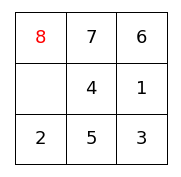

In [6]:
plot_state(test_state, hint = 8)

Affichage graphique d'une solution par stockage sur disque des étapes de cette solution.

In [11]:
def write_sol(state, sol, prefix):
    """Stockage"""
    prefix = f'{global_prefix}images/{prefix}-'
    for c, action in enumerate(sol):
        plot_state(state, file = f'{prefix}{c}', hint = action)
        state = delta(state,action)
    plot_state(state, file = f'{prefix}{len(sol)}')

def display_sol(sol, prefix):
    import displayImages
    return displayImages.widgets(f'{global_prefix}images/{prefix}-', len(sol))
    #return displayImages.mpl(f'{global_prefix}images/8-puzzle/{prefix}-', len(sol))

Test

In [9]:
write_sol(test_state, test_sol, 'test')

In [12]:
display_sol(test_sol, 'test')

interactive(children=(IntSlider(value=0, description='t', max=31), Output()), _dom_classes=('widget-interact',…

Button(description='▷', style=ButtonStyle())

##### Remarque (autre méthode)
 Comme le problème du 8-puzzle est de dimension raisonnable, on introduit la liste des $N=9!=362\,880$ permutations de $[|0,8|]$ et on représente un état par son indice $k$ dans la liste. Soit le graphe $G$ dont les sommets sont les $N$ indices des états, et les arêtes les $(k,\ell)\in[|0,N - 1|]^2$ pour lesquels on peut passer de l'état d'indice $k$ à l'état d'indice $\ell$ en un coup. Comme ce graphe est seulement de degré 4, on peut représenter sa matrice par un élément de type `scipy.sparse.lil_matrix` qui est une manière efficace de stocker une matrice creuse. 

 On utilise alors [l'algorithme de Dijkstra](https://fr.wikipedia.org/wiki/Algorithme_de_Dijkstra) pour caculer une fois pour toutes les distances minimums (en terme de nombre d'arêtes) de l'état identité $(0,\ldots,8)$ à tous les autres états, ainsi que les chemins correspondants.

La fonction `scipy.sparse.csgraph.dijkstra` renvoie le couple $d,pred$ tel que, si $p$ est l'état d'indice $k$,
- $d[k]=$ distance($p$,identité) ou `np.inf` si l'identité n'est pas accessible de $p$
- $pred[k]=\ell$ où la première arête d'un chemin optimal de $p$ à l'identité est $p\rightarrow q$ avec $q$ d'indice $\ell$ ; sauf si $p$ est l'identité ou si l'identité n'est pas accessible de $p$, auquel cas $\ell<0$


In [13]:
import time
from itertools import permutations
import numpy as np
from scipy.sparse import lil_matrix 
from scipy.sparse.csgraph import dijkstra

# indices des états (l'identité est d'indice 0)

n = 3
n_2 = n * n
etats = list(permutations(range(n_2)))
N = len(etats)
indice = dict()

for k, etat in enumerate(etats):
    indice[etat] = k

# Construction du graphe (complexité O(N))
start_time = time.time()

G = lil_matrix((N, N), dtype=np.int8)

def echange(etat,k,l):
    p = list(etat)
    aux = p[k]
    p[k] = p[l]
    p[l] = aux
    return tuple(p)

for etat in etats:    
    k = etat.index(0)
    def ajouter_arete(l):
        G[indice[etat],indice[echange(etat, k, l)]] = 1
    if k >= n: ajouter_arete(k - n)
    if k < n_2 - n: ajouter_arete(k + n)
    if k % n != 0: ajouter_arete(k - 1)
    if k % n != n - 1: ajouter_arete(k + 1)

print('Construction du graphe en {0:0.2f} s'.format(time.time() - start_time))

# Application de l'algorithme de Dijkstra (complexité O(N log(N)))
start_time = time.time()

d, pred = dijkstra(csgraph = G, unweighted = True, directed = False, indices = 0, return_predecessors = True)

print("Calcul de tous les chemins optimaux aboutissant à l'identité en {0:0.2f} s".format(time.time() - start_time))

# On peut par exemple chercher les états les plus éloignés de l'identité

m = max(x for x in d if x != np.inf)
print(f"distance à l'identité maximale = {int(m)}")
pd = [etats[i] for i in range(N) if d[i] == m]
print(f'atteinte par les états : ', end = '')
for p in pd: print(p, end = ' ')

Construction du graphe en 8.71 s
Calcul de tous les chemins optimaux aboutissant à l'identité en 0.42 s
distance à l'identité maximale = 31
atteinte par les états : (8, 0, 6, 5, 4, 7, 2, 3, 1) (8, 7, 6, 0, 4, 1, 2, 5, 3) 